In [1]:
from openTSNE import TSNE, TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt

In [2]:
import anndata
import scanpy as sc

/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
adata = anndata.read_h5ad(path.join("..", "data", "macosko_2015.h5ad"))
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 44808 × 23743 
    obs: 'batch_id', 'cluster_id', 'labels'
    var: 'genes_1000', 'genes_3000', 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 0.08
Chosen offset: 0.19
Chosen offset: 0.71


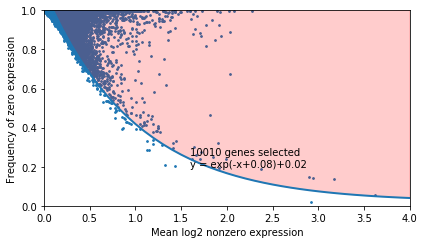

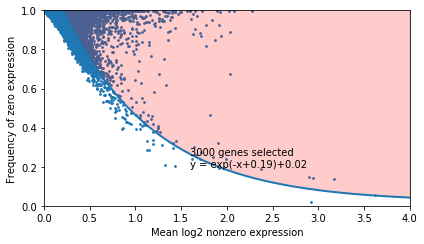

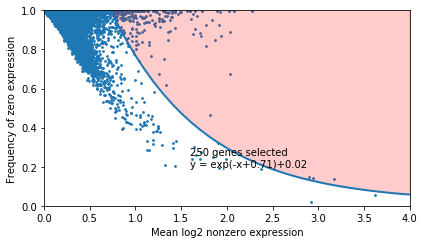

In [4]:
gene_mask_10000 = utils.select_genes(adata.X, n=10000, threshold=0)
gene_mask_3000 = utils.select_genes(adata.X, n=3000, threshold=0)
gene_mask_250 = utils.select_genes(adata.X, n=250, threshold=0)

In [5]:
adata_norm = adata.copy()
sc.pp.normalize_per_cell(adata_norm, counts_per_cell_after=1_000_000)
sc.pp.log1p(adata_norm)

In [6]:
adata_norm.X = adata_norm.X.toarray()
adata_norm.X -= adata_norm.X.mean(axis=0)
adata_norm.X /= adata_norm.X.std(axis=0)

In [7]:
adata_250 = adata_norm[:, gene_mask_250].copy()
adata_3000 = adata_norm[:, gene_mask_3000].copy()
adata_10000 = adata_norm[:, gene_mask_10000].copy()

In [8]:
%%time
for adata_ in [adata_250, adata_3000, adata_10000]:
    print("Computing PCA for %d genes" % adata_.shape[1])
    U, S, V = np.linalg.svd(adata_.X, full_matrices=False)
    U[:, np.sum(V, axis=1) < 0] *= -1
    adata_.obsm["pca"] = np.dot(U, np.diag(S))
    adata_.obsm["pca"] = adata_.obsm["pca"][:, np.argsort(S)[::-1]][:, :50]

Computing PCA for 250 genes
Computing PCA for 3000 genes
Computing PCA for 10010 genes
CPU times: user 1h 13min 4s, sys: 3min 24s, total: 1h 16min 28s
Wall time: 2min 38s


## Run t-SNE

In [9]:
%%time
for adata_ in [adata_250, adata_3000, adata_10000]:
    print("Computing t-SNE for %d genes" % adata_.shape[1])
    affinities = affinity.Multiscale(
        adata_.obsm["pca"],
        perplexities=[50, 500],
        metric="cosine",
        n_jobs=8,
        random_state=3,
    )
    init = initialization.pca(adata_.obsm["pca"], random_state=42)
    embedding = TSNEEmbedding(
        init,
        affinities,
        negative_gradient_method="fft",
        n_jobs=8,
    )
    embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
    embedding.optimize(n_iter=750, exaggeration=1, momentum=0.8, inplace=True)
    
    adata_.obsm["tsne"] = embedding

Computing t-SNE for 250 genes
Computing t-SNE for 3000 genes
Computing t-SNE for 10010 genes
CPU times: user 7h 26min 7s, sys: 8min 6s, total: 7h 34min 14s
Wall time: 24min 3s


In [10]:
adata_250.write_h5ad("macosko_embedding_tsne_250_genes.h5ad")
adata_3000.write_h5ad("macosko_embedding_tsne_3000_genes.h5ad")
adata_10000.write_h5ad("macosko_embedding_tsne_10000_genes.h5ad")

In [11]:
adata_250 = anndata.read_h5ad("macosko_embedding_tsne_250_genes.h5ad")
adata_3000 = anndata.read_h5ad("macosko_embedding_tsne_3000_genes.h5ad")
adata_10000 = anndata.read_h5ad("macosko_embedding_tsne_10000_genes.h5ad")

In [12]:
legend_kwargs = dict(loc="center", bbox_to_anchor=(0.5, -0.05), ncol=len(np.unique(adata.obs["labels"])))

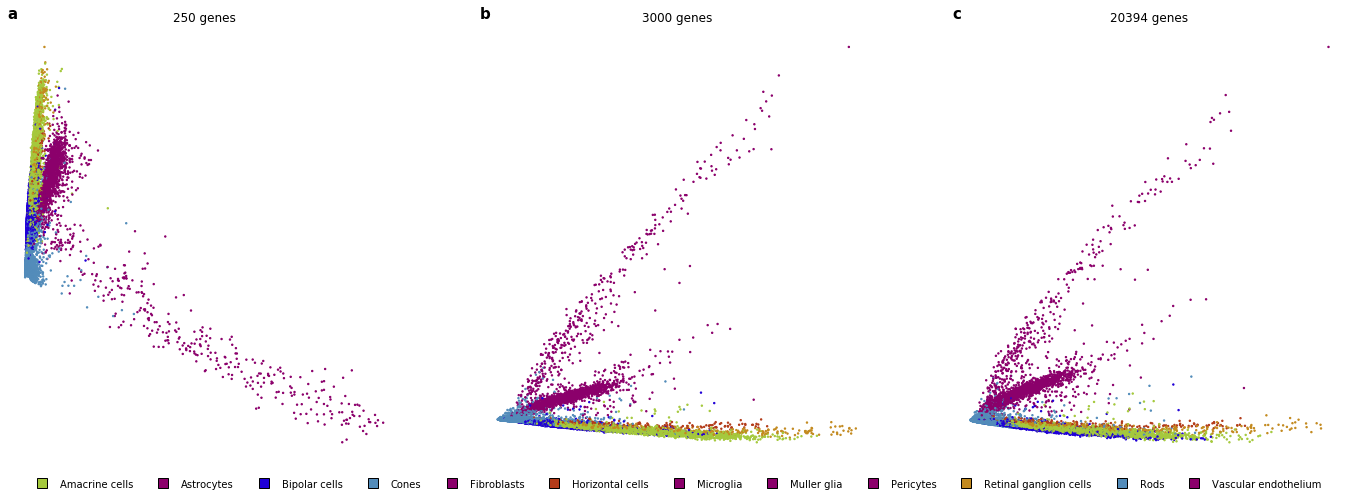

In [18]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_250.obsm["pca"], adata.obs["labels"],  s=2, colors=utils.MACOSKO_COLORS, draw_legend=False, ax=ax[0], alpha=1, title="250 genes", label_order=list(utils.MACOSKO_COLORS.keys()))
utils.plot(adata_3000.obsm["pca"], adata.obs["labels"], s=2, colors=utils.MACOSKO_COLORS, draw_legend=True, ax=ax[1], alpha=1, title="3000 genes", label_order=list(utils.MACOSKO_COLORS.keys()),
          legend_kwargs=legend_kwargs)
utils.plot(adata_10000.obsm["pca"], adata.obs["labels"], s=2, colors=utils.MACOSKO_COLORS, draw_legend=False, ax=ax[2], alpha=1, title="20394 genes", label_order=list(utils.MACOSKO_COLORS.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

plt.savefig("macosko_embedding_pca_genes.png", dpi=100, bbox_inches="tight", transparent=True)
plt.savefig("macosko_embedding_pca_genes.pdf", dpi=600, bbox_inches="tight", transparent=True)

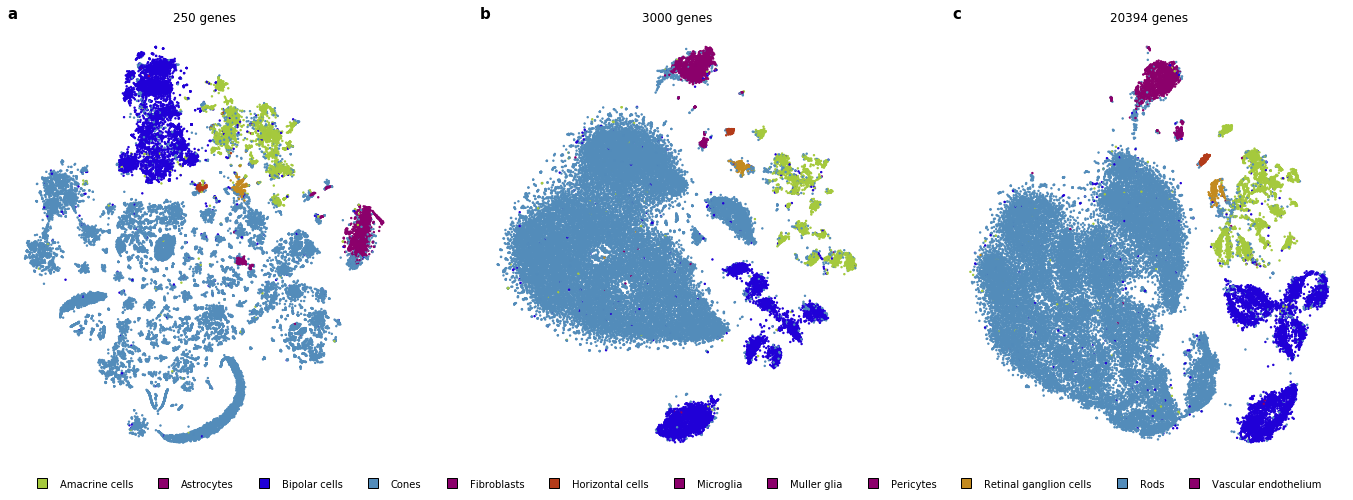

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_250.obsm["tsne"],  adata.obs["labels"], s=2, colors=utils.MACOSKO_COLORS, draw_legend=False, ax=ax[0], alpha=1, title="250 genes", label_order=list(utils.MACOSKO_COLORS.keys()))
utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=2, colors=utils.MACOSKO_COLORS, draw_legend=True, ax=ax[1], alpha=1, title="3000 genes", label_order=list(utils.MACOSKO_COLORS.keys()),
           legend_kwargs=legend_kwargs)
utils.plot(adata_10000.obsm["tsne"], adata.obs["labels"], s=2, colors=utils.MACOSKO_COLORS, draw_legend=False, ax=ax[2], alpha=1, title="20394 genes", label_order=list(utils.MACOSKO_COLORS.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

plt.savefig("macosko_embedding_tsne_genes.png", dpi=100, bbox_inches="tight", transparent=True)
plt.savefig("macosko_embedding_tsne_genes.pdf", dpi=600, bbox_inches="tight", transparent=True)

## Transform

In [19]:
new = anndata.read_h5ad(path.join("..", "data", "shekhar_2016.h5ad"))

In [20]:
new.obs["labels"].value_counts()

Bipolar cells     23494
Muller glia        2945
Amacrine cells      252
Rods                 91
Cones                48
Name: labels, dtype: int64

In [21]:
cell_mask = new.obs["labels"].isin(adata.obs["labels"])
cell_mask.sum()

26830

In [22]:
new = new[cell_mask].copy()

In [23]:
shared_genes = adata.var_names[adata.var_names.isin(new.var_names)]
shared_genes

Index(['0610005C13RIK', '0610007P14RIK', '0610009B22RIK', '0610009E02RIK',
       '0610009L18RIK', '0610009O20RIK', '0610010F05RIK', '0610010K14RIK',
       '0610011F06RIK', '0610025J13RIK',
       ...
       'ZUFSP', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='index', length=20512)

In [24]:
adata = adata[:, adata.var_names.isin(shared_genes)]
new = new[:, new.var_names.isin(shared_genes)]

In [25]:
adata = adata[:, adata.var_names.argsort()].copy()
new = new[:, new.var_names.argsort()].copy()
assert all(adata.var_names == new.var_names)

Chosen offset: 0.71
Chosen offset: 0.36
Chosen offset: 0.14


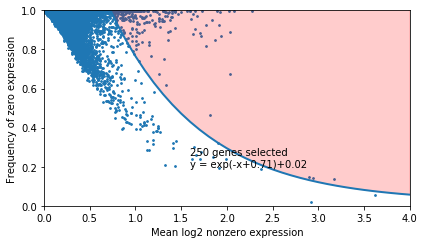

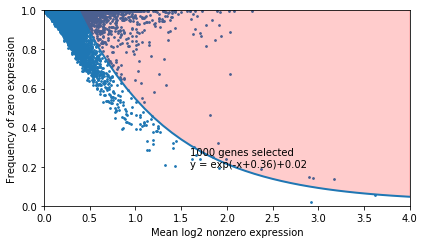

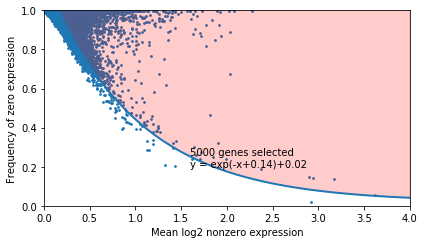

In [26]:
gene_mask_250 = utils.select_genes(adata.X, n=250, threshold=0)
gene_mask_1000 = utils.select_genes(adata.X, n=1000, threshold=0)
gene_mask_5000 = utils.select_genes(adata.X, n=5000, threshold=0)

In [27]:
adata_250 = adata[:, gene_mask_250].copy()
adata_1000 = adata[:, gene_mask_1000].copy()
adata_5000 = adata[:, gene_mask_5000].copy()

new_250 = new[:, gene_mask_250].copy()
new_1000 = new[:, gene_mask_1000].copy()
new_5000 = new[:, gene_mask_5000].copy()

In [44]:
%%time
affinity_obs = {}
for adata_, new_ in [(adata_250, new_250), (adata_1000, new_1000), (adata_5000, new_5000)]:
    print("Running transform for %d genes" % adata_.shape[1])
    affinities = affinity.PerplexityBasedNN(
        adata_.X.toarray() if sp.issparse(adata_.X) else adata_.X,
        perplexity=30,
        metric="cosine",
        n_jobs=8,
        random_state=3,
    )
    affinity_obs[adata_.shape[1]] = affinities
    embedding = TSNEEmbedding(
        adata_3000.obsm["tsne"],
        affinities,
        negative_gradient_method="fft",
        n_jobs=8,
        callbacks=[ErrorLogger()],
    )
    new_embedding = embedding.prepare_partial(new_.X.toarray(), k=10)
    new_.obsm["tsne_init"] = new_embedding.copy()
    
    new_embedding.optimize(250, learning_rate=0.1, momentum=0.8, max_grad_norm=0.25, inplace=True)
    new_.obsm["tsne"] = new_embedding

Running transform for 250 genes
Iteration   50, KL divergence  380856.9593, 50 iterations in 4.1345 sec
Iteration  100, KL divergence  380772.9413, 50 iterations in 5.8495 sec
Iteration  150, KL divergence  380726.6548, 50 iterations in 4.7910 sec
Iteration  200, KL divergence  380654.4255, 50 iterations in 5.8727 sec
Iteration  250, KL divergence  380606.1833, 50 iterations in 7.1746 sec
Running transform for 1000 genes
Iteration   50, KL divergence  371642.2370, 50 iterations in 3.6952 sec
Iteration  100, KL divergence  371568.0902, 50 iterations in 2.8460 sec
Iteration  150, KL divergence  371546.6514, 50 iterations in 4.0348 sec
Iteration  200, KL divergence  371535.7010, 50 iterations in 5.4779 sec
Iteration  250, KL divergence  371528.6095, 50 iterations in 6.8143 sec
Running transform for 5000 genes
Iteration   50, KL divergence  388941.9269, 50 iterations in 3.7633 sec
Iteration  100, KL divergence  388708.9396, 50 iterations in 3.0745 sec
Iteration  150, KL divergence  388633.

In [45]:
new_250.write_h5ad("macosko_transform_tsne_250_genes.h5ad")
new_1000.write_h5ad("macosko_transform_tsne_1000_genes.h5ad")
new_5000.write_h5ad("macosko_transform_tsne_5000_genes.h5ad")

In [46]:
new_250 = anndata.read_h5ad("macosko_transform_tsne_250_genes.h5ad")
new_1000 = anndata.read_h5ad("macosko_transform_tsne_1000_genes.h5ad")
new_5000 = anndata.read_h5ad("macosko_transform_tsne_5000_genes.h5ad")

In [47]:
new_5000.shape

(26830, 5000)

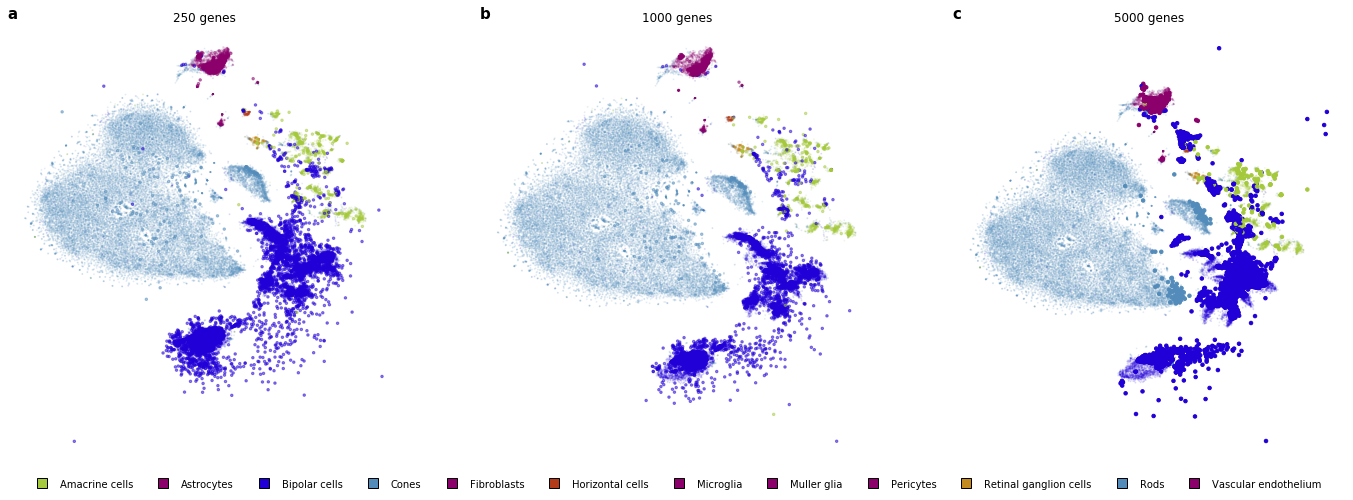

In [48]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=1, colors=utils.MACOSKO_COLORS, draw_legend=False, ax=ax[0], alpha=0.1, title="250 genes", label_order=list(utils.MACOSKO_COLORS.keys()))
utils.plot(new_250.obsm["tsne"], new.obs["labels"], s=6, colors=utils.MACOSKO_COLORS, draw_legend=False, ax=ax[0], alpha=0.5, label_order=list(utils.MACOSKO_COLORS.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=1, colors=utils.MACOSKO_COLORS, draw_legend=True, ax=ax[1], alpha=0.1, title="1000 genes", label_order=list(utils.MACOSKO_COLORS.keys()),
          legend_kwargs=legend_kwargs)
utils.plot(new_1000.obsm["tsne"], new.obs["labels"], s=6, colors=utils.MACOSKO_COLORS, draw_legend=False, ax=ax[1], alpha=0.5, label_order=list(utils.MACOSKO_COLORS.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=1, colors=utils.MACOSKO_COLORS, draw_legend=False, ax=ax[2], alpha=0.1, title="5000 genes", label_order=list(utils.MACOSKO_COLORS.keys()))
utils.plot(new_5000.obsm["tsne"], new.obs["labels"], s=12, colors=utils.MACOSKO_COLORS, draw_legend=False, ax=ax[2], alpha=1, label_order=list(utils.MACOSKO_COLORS.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

plt.savefig("macosko_transform_tsne_genes.png", dpi=100, bbox_inches="tight", transparent=True)
plt.savefig("macosko_transform_tsne_genes.pdf", dpi=600, bbox_inches="tight", transparent=True)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[0, 0], alpha=0.1, title="Initialization", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne_init"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[0, 0], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[0, 1], alpha=0.1, title="250 genes", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[0, 1], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[1, 0], alpha=0.1, title="1000 genes", label_order=list(colors.keys()))
utils.plot(new_1000.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[1, 0], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=True, ax=ax[1, 1], alpha=0.1, title="17078 genes", label_order=list(colors.keys()),
          legend_kwargs=dict(bbox_transform=fig.transFigure, loc="lower center", bbox_to_anchor=(0.5, 0.075), ncol=len(np.unique(adata.obs["labels"]))))
utils.plot(new_full.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[1, 1], alpha=1, label_order=list(colors.keys()))

#fig.tight_layout()

fig.text(0, 1.02, "a", transform=ax[0, 0].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "b", transform=ax[0, 1].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "c", transform=ax[1, 0].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "d", transform=ax[1, 1].transAxes, fontsize=15, fontweight="bold")